<a href="https://colab.research.google.com/github/WNderitu/data_science_capstone_project/blob/main/malaria_parasite_object_detection_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plasmodium Vivax (malaria) parasite detector and counter**

## **1.0 Introduction**

## **1.1 Problem Statement**

## **1.2 Objectives**

1. To detect Plasmodium Vivax (malaria parasite) in human cells
2. To count the number of detected plasmodium vivax parasites per image

## **1.3 Image dataset**

Dataset courced from: https://bbbc.broadinstitute.org/BBBC041/

The dataset consists of:
- image folder
- training json file
- test json file

The dataset consists of 1,328 microscopic images of blood smears

Upon downloading the dataset, a folder called labels was created and the two json files moved to the folder.

The training json file was renamed to train.json

## **1.4 Installing & Importing Required Libraries**

In [ ]:
!pip install Pillow #installing PILLOW LIBRARY

In [ ]:
!pip install matplotlib

In [ ]:
!pip install imagehash

In [ ]:
!pip install pyyaml

In [80]:
import os
import json
import random
import shutil
from pprint import pprint #
import PIL
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import Counter
import hashlib # find identical images
from collections import defaultdict
import imagehash # find visually identical images
import numpy as np
import yaml

In [ ]:
    !pip install ultralytics

## **1.5 Loading & Understanding Malaria Dataset structure**

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
# load malaria folder
%cd /content/drive/MyDrive/malaria

/content/drive/MyDrive/malaria


In [83]:
# Look inside the malaria folder
print("Contents of malaria/:", os.listdir("/content/drive/MyDrive/malaria"))

Contents of malaria/: ['.DS_Store', 'labels', 'images']


In [84]:
# Look inside the labels sub folder in malaria folder
print("Contents of labels/:", os.listdir("/content/drive/MyDrive/malaria/labels"))

Contents of labels/: ['test.json', 'train.json']


In [85]:
# Look inside the images sub folder in malaria folder
print("Contents of images/:", os.listdir("/content/drive/MyDrive/malaria/images"))

Contents of images/: ['c415532c-4cce-4580-9fcd-623c172a1abd.png', '1d4f06e1-9c9b-487e-84cd-e7e50cc754da.png', '6473ddb6-ad56-48a2-81e8-c7cb45f06825.png', 'f4c00b8c-d675-4255-8277-ca65bd757f51.png', '43158031-a335-4533-9c20-48bebba90123.png', 'e98baeb2-aa58-4cce-8c61-66685dd2b239.png', 'e597f7ce-46c6-4dce-9063-50a2703fdd45.png', '99b13257-b9d9-422f-8262-802da0bdc510.png', '19370afd-f897-47d8-bfae-c0d257bbf795.png', 'a86e0647-ae41-4b75-9d45-dd58f5ea65f5.png', '592c941a-aa54-4971-b499-dc47356f80a3.png', 'afbb264e-ff60-443a-83f5-49d09be1b835.png', 'df3d98b9-3dd7-4107-8d4a-ae1b7f247793.png', '24879caf-a327-464c-9cd9-e0f3d9161079.png', '7bcd3735-3134-46d1-8ca2-d4379f2d51c0.png', '04a567df-5463-4043-81f1-d726223c19a9.png', '997eabd9-55bf-4683-83c4-4cee4673a4ef.png', '3d1b889e-bb4a-4ee6-b899-974ee7d956a7.png', '1f8f08ea-b5b3-4f68-94d4-3cc071b7dce8.png', 'fcc2b245-f47f-447f-8527-275b0005677c.png', '02fb5e19-6f94-4787-bb78-e550a29a3cbd.png', '58ced55c-bf0d-4204-b6b2-4f8992d92779.png', 'f3d84be2-

In [86]:
# List all files ending in common image extensions
# Path to your images
image_folder = "/content/drive/MyDrive/malaria/images"

image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# print the results
print(f"Number of images in '{image_folder}': {len(image_files)}")
print("Example files:", image_files[:5])

Number of images in '/content/drive/MyDrive/malaria/images': 1328
Example files: ['c415532c-4cce-4580-9fcd-623c172a1abd.png', '1d4f06e1-9c9b-487e-84cd-e7e50cc754da.png', '6473ddb6-ad56-48a2-81e8-c7cb45f06825.png', 'f4c00b8c-d675-4255-8277-ca65bd757f51.png', '43158031-a335-4533-9c20-48bebba90123.png']


In [87]:
# extract file names from JSON files
train_json = "/content/drive/MyDrive/malaria/labels/train.json"
test_json  = "/content/drive/MyDrive/malaria/labels/test.json"

# Function to extract image filenames
def get_image_names(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # The image pathnames in the JSON start with '/images/', extract just the filename
    return [os.path.basename(img['image']['pathname']) for img in data]

# Get image filenames
train_images = get_image_names(train_json)
test_images = get_image_names(test_json)


print(f"Number of train images listed in {train_json}: {len(train_images)}")
print(f"Number of test images listed in {test_json}: {len(test_images)}")

Number of train images listed in /content/drive/MyDrive/malaria/labels/train.json: 1208
Number of test images listed in /content/drive/MyDrive/malaria/labels/test.json: 120


In [88]:
with open(train_json) as f:
    data = json.load(f)

print(type(data))
print(data[0] if isinstance(data, list) else list(data.keys())[:5])

<class 'list'>
{'image': {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af', 'pathname': '/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png', 'shape': {'r': 1200, 'c': 1600, 'channels': 3}}, 'objects': [{'bounding_box': {'minimum': {'r': 1057, 'c': 1440}, 'maximum': {'r': 1158, 'c': 1540}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 868, 'c': 1303}, 'maximum': {'r': 971, 'c': 1403}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 578, 'c': 900}, 'maximum': {'r': 689, 'c': 1008}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 304, 'c': 611}, 'maximum': {'r': 408, 'c': 713}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 198, 'c': 881}, 'maximum': {'r': 312, 'c': 1003}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 193, 'c': 1480}, 'maximum': {'r': 293, 'c': 1574}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 257, 'c': 1384}, 'maximum': {'r': 364, 'c': 1502}}, 'categor

## **1.6 Data cleaning & preparation for object detection task**

### **1.6.1 Split images in image folder into 2 folders: test & train images**

This will be necessary for the YOLO model

In [ ]:
# Split images in image folder into 2 folders: test & train images.

# Define dataset paths
base_dir = '/content/drive/MyDrive/malaria'
images_dir = os.path.join(base_dir, 'images')
train_json = os.path.join(base_dir, 'labels', 'train.json')
test_json = os.path.join(base_dir, 'labels', 'test.json')

train_img_dir = os.path.join(base_dir, 'images', 'train')
test_img_dir = os.path.join(base_dir, 'images', 'test')

# Create output folders
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)

# Function to extract filenames from JSON
def get_image_names(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return [os.path.basename(img_data['image']['pathname']) for img_data in data]

# Get the list of train and test image filenames from the JSON files
train_images = get_image_names(train_json)
test_images  = get_image_names(test_json)

# Move images to respective folders
print("Splitting images...")
for img_name in train_images:
    src = os.path.join(images_dir, img_name)
    dst = os.path.join(train_img_dir, img_name)
    if os.path.exists(src):
        shutil.move(src, dst)
    else:
        print(f" Missing train image: {img_name}")

for img_name in test_images:
    src = os.path.join(images_dir, img_name)
    dst = os.path.join(test_img_dir, img_name)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f" Missing test image: {img_name}")

print(" Images successfully split into images/train and images/test folders.")

**Verify image splitting process**

In [91]:
# Define the paths to the new image directories
train_img_dir = '/content/drive/MyDrive/malaria/images/train'
test_img_dir = '/content/drive/MyDrive/malaria/images/test'

# Count the number of files in each directory
num_train_images_folder = len(os.listdir(train_img_dir))
num_test_images_folder = len(os.listdir(test_img_dir))

print(f"Number of images found in '{train_img_dir}': {num_train_images_folder}")
print(f"Number of images found in '{test_img_dir}': {num_test_images_folder}")

# Compare these numbers to the counts extracted from the JSON files earlier
# (assuming train_images and test_images lists are still available in the environment)
if 'train_images' in locals() and 'test_images' in locals():
    print(f"Expected number of train images from JSON: {len(train_images)}")
    print(f"Expected number of test images from JSON: {len(test_images)}")

    if num_train_images_folder == len(train_images):
        print("The number of images in train/images matches the number in train.json.")
    else:
        print("The number of images in train/images does NOT match the number in train.json.")

    if num_test_images_folder == len(test_images):
        print("The number of images in test/images matches the number in test.json.")
    else:
        print("The number of images in test/images does NOT match the number in test.json.")
else:
    print("Could not compare with JSON counts as train_images or test_images variables are not available.")

Number of images found in '/content/drive/MyDrive/malaria/images/train': 1208
Number of images found in '/content/drive/MyDrive/malaria/images/test': 120
Expected number of train images from JSON: 1208
Expected number of test images from JSON: 120
The number of images in train/images matches the number in train.json.
The number of images in test/images matches the number in test.json.


In [92]:
# Look inside the malaria folder to see folder structure
print("Contents of malaria/:", os.listdir("/content/drive/MyDrive/malaria"))

Contents of malaria/: ['.DS_Store', 'labels', 'images']


### **1.6.2 Check if all images have corresponding image names in json files**

In [93]:
# Check if all train images have corresponding image names in train.json files
with open(train_json, 'r') as f:
    train_data = json.load(f)
    train_images = [os.path.basename(item["image"]["pathname"]) for item in train_data]
    missing_train = [img for img in train_images if img not in os.listdir(train_img_dir)]
    print(f"\nImages listed in train.json: {len(train_images)}")


Images listed in train.json: 1208


In [94]:
# Check if all test images have corresponding image names in test.json files
with open(test_json, 'r') as f:
    test_data = json.load(f)
    test_images = [os.path.basename(item["image"]["pathname"]) for item in test_data]
    missing_train = [img for img in test_images if img not in os.listdir(test_img_dir)]
    print(f"\nImages listed in test.json: {len(test_images)}")


Images listed in test.json: 120


### **1.6.3 Collect all category names from images**

In [95]:
# collect category names from train images
all_categories = []
for img_data in train_data:
    for obj in img_data["objects"]:
        all
        all_categories.append(obj["category"])
        unique_categories = sorted(set(all_categories))

print("Unique labels found in train dataset:", unique_categories)

# number of categories
print(f"Number of categories: {len(unique_categories)}")

Unique labels found in train dataset: ['difficult', 'gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']
Number of categories: 7


In [96]:
# collect category names from test images
all_categories = []
for img_data in test_data:
    for obj in img_data["objects"]:
        all
        all_categories.append(obj["category"])
        unique_categories = sorted(set(all_categories))

print("Unique labels found in test dataset:", unique_categories)

# number of categories
print(f"Number of categories: {len(unique_categories)}")

Unique labels found in test dataset: ['difficult', 'gametocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']
Number of categories: 6


### **1.6.4 View images in train image folders**

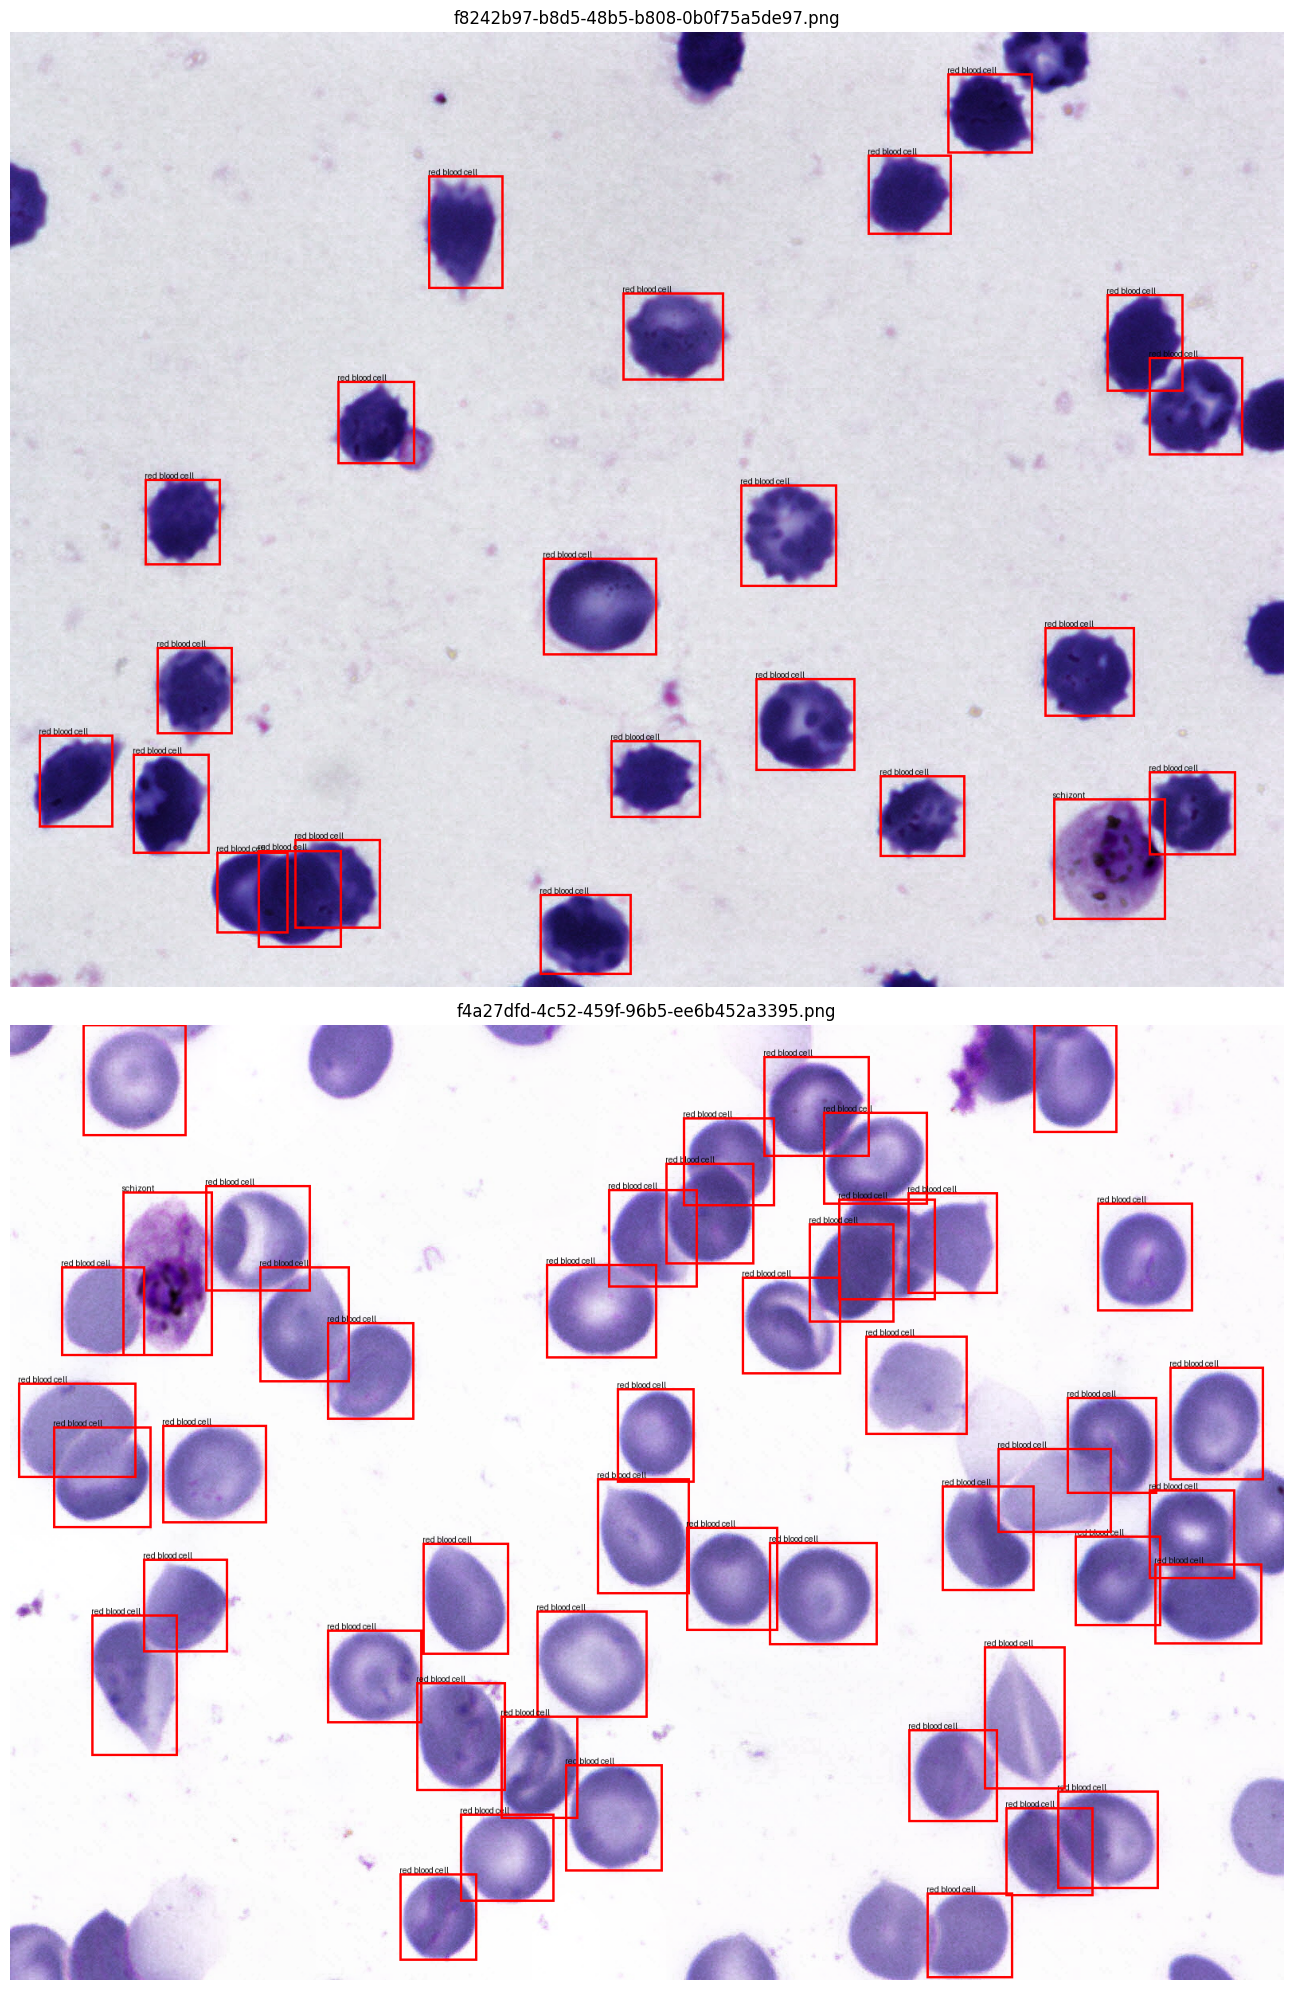

In [98]:
# view train images

# Randomly sample 2 images from the train data
train_samples = random.sample(train_data, 2)

# Define the path to the train images folder
train_img_folder = "/content/drive/MyDrive/malaria/images/train"

# Try loading a font (fallback to default)
try:
    font = ImageFont.truetype("arial.ttf", 34)
except:
    font = ImageFont.load_default()

plt.figure(figsize=(20, 20))

for idx, sample in enumerate(train_samples):
    # Construct the full image path
    img_name = os.path.basename(sample["image"]["pathname"])
    img_path = os.path.join(train_img_folder, img_name)

    try:
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        for obj in sample["objects"]:
            box = obj["bounding_box"]
            xmin, ymin = box["minimum"]["c"], box["minimum"]["r"]
            xmax, ymax = box["maximum"]["c"], box["maximum"]["r"]
            category = obj["category"]
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
            draw.text((xmin, ymin - 10), category, fill="black", font=font)

        plt.subplot(2, 1, idx + 1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis("off")

    except FileNotFoundError:
        print(f"Image file not found: {img_path}")
    except Exception as e:
        print(f"Error processing image {img_name}: {e}")


plt.tight_layout()
plt.show()

### **1.6.5 Check for corrupted images & remove**

In [99]:
# Open each image in train folder and check if corrupted
image_folder = "/content/drive/MyDrive/malaria/images/train/"
image_files = os.listdir(image_folder) # Correctly call os.listdir

corrupted_images = []
for filename in image_files:
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        try:
            img = Image.open(path)
            img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {filename}")
            # Optionally, remove the corrupted file:
            # os.remove(path)
            # print(f"Removed corrupted image: {filename}")
            corrupted_images.append(filename)

if not corrupted_images:
    print("No corrupted images found in the train folder.")

No corrupted images found in the train folder.


In [101]:
# Open each image in test folder and check if corrupted
image_folder = "/content/drive/MyDrive/malaria/images/test/" # Corrected path to test images
image_files = os.listdir(image_folder) # Correctly call os.listdir

corrupted_images = []
for filename in image_files:
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        try:
            img = Image.open(path)
            img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {filename}")
            # Optionally, remove the corrupted file:
            # os.remove(path)
            # print(f"Removed corrupted image: {filename}")
            corrupted_images.append(filename)

if not corrupted_images:
    print("No corrupted images found in the test folder.")

No corrupted images found in the test folder.


### **1.6.6 Check duplicate images**

In [102]:
# Check duplicate images in train images folder

# Function to compute hash
def file_hash(filepath):
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Define the path to the train images folder
image_folder = "/content/drive/MyDrive/malaria/images/train/"

# Compute hashes for all images in the train folder
hash_dict = defaultdict(list)
for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        h = file_hash(path)
        hash_dict[h].append(filename)

# Report duplicates
duplicates = {h: files for h, files in hash_dict.items() if len(files) > 1}

print(f"Found {len(duplicates)} groups of duplicate images in the train folder.")
for h, files in list(duplicates.items())[:5]:  # show first 5 examples
    print("→", files)

Found 0 groups of duplicate images in the train folder.


In [103]:
# Check duplicate images in test images

# Function to compute hash
def file_hash(filepath):
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Define the path to the test images folder
image_folder = "/content/drive/MyDrive/malaria/images/test/"

# Compute hashes for all images in the test folder
hash_dict = defaultdict(list)
for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        h = file_hash(path)
        hash_dict[h].append(filename)

# Report duplicates
duplicates = {h: files for h, files in hash_dict.items() if len(files) > 1}

print(f"Found {len(duplicates)} groups of duplicate images in the test folder.")
for h, files in list(duplicates.items())[:5]:  # show first 5 examples
    print("→", files)

Found 0 groups of duplicate images in the test folder.


### **1.6.7 Check visually similar images**

In [108]:
# Check visually similar images in train images
image_folder = "/content/drive/MyDrive/malaria/images/train/"

hash_dict = defaultdict(list)

for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        img = Image.open(path)
        h = str(imagehash.phash(img))  # perceptual hash
        hash_dict[h].append(filename)

duplicates = {h: files for h, files in hash_dict.items() if len(files) > 1}

print(f"Found {len(duplicates)} visually duplicate groups.")
for h, files in list(duplicates.items())[:5]:
    print("→", files)

Found 1 visually duplicate groups.
→ ['3061aac0-cda3-47d1-8c48-6293e9ffdf36.png', 'f329e01b-fbd3-4fb5-9738-a7ff4c8622b8.png']


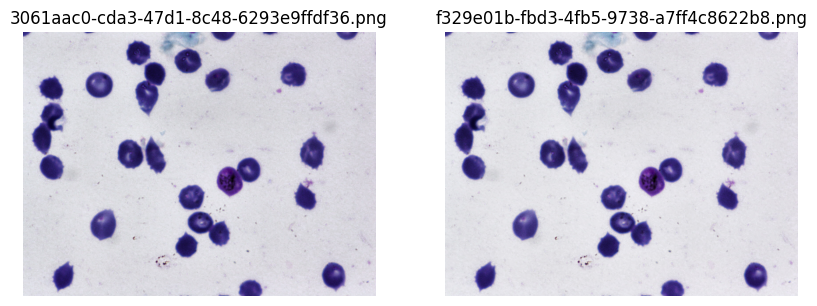

In [109]:
# Show the first two duplicates side by side
imgs = [Image.open(os.path.join(image_folder, f)) for f in files[:2]]
plt.figure(figsize=(10,4))
for i, img in enumerate(imgs):
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title(files[i])
    plt.axis("off")
plt.show()

In [107]:
# Check visually similar images in test images
image_folder = "/content/drive/MyDrive/malaria/images/test/"

hash_dict = defaultdict(list)

for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        img = Image.open(path)
        h = str(imagehash.phash(img))  # perceptual hash
        hash_dict[h].append(filename)

duplicates_test = {h: files for h, files in hash_dict.items() if len(files) > 1}

print(f"Found {len(duplicates_test)} visually duplicate groups.")
for h, files in list(duplicates_test.items())[:5]:
    print("→", files)

Found 0 visually duplicate groups.


In [110]:
# Remove duplicate image
removed_count = 0
for h, files in duplicates.items():
    # Keep the first file and remove the rest
    files_to_remove = files[1:]
    for file_to_remove in files_to_remove:
        file_path = os.path.join(image_folder, file_to_remove)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Removed duplicate: {file_to_remove}")
            removed_count += 1
        else:
            print(f"Warning: Duplicate file not found: {file_to_remove}")

print(f"\nFinished removing duplicates. Total removed: {removed_count}")

Removed duplicate: f329e01b-fbd3-4fb5-9738-a7ff4c8622b8.png

Finished removing duplicates. Total removed: 1


### **1.6.8 Check for mislabelled images in train data**

In [111]:
# Collect all category names
all_categories = [obj["category"] for img in train_data for obj in img["objects"]]
unique_categories = sorted(set(all_categories))

print("Unique labels found in train dataset:", unique_categories)

# If you expect only these categories:
expected_labels = {'difficult','gametocyte','leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite'}

# Check for unexpected labels
unexpected = [c for c in unique_categories if c not in expected_labels]
if unexpected:
    print("Found unexpected or misspelled categories:", unexpected)
else:
    print("All labels match expected categories.")

Unique labels found in train dataset: ['difficult', 'gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']
All labels match expected categories.


### **1.6.9 Check for mislabelled images in test data**

In [112]:
# Collect all category names
all_categories = [obj["category"] for img in test_data for obj in img["objects"]]
unique_categories = sorted(set(all_categories))

print("Unique labels found in test dataset:", unique_categories)

# If you expect only these categories:
expected_labels = {'difficult','gametocyte','leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite'}

# Check for unexpected labels
unexpected = [c for c in unique_categories if c not in expected_labels]
if unexpected:
    print("Found unexpected or misspelled categories:", unexpected)
else:
    print("All labels match expected categories.")

Unique labels found in test dataset: ['difficult', 'gametocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']
All labels match expected categories.


### **1.6.10 Check for any bounding box issues in train data**

In [113]:
bad_boxes = []

for img_data in train_data:
    img_name = os.path.basename(img_data["image"]["pathname"])
    w = img_data["image"]["shape"]["c"]
    h = img_data["image"]["shape"]["r"]
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        xmin, ymin = box["minimum"]["c"], box["minimum"]["r"]
        xmax, ymax = box["maximum"]["c"], box["maximum"]["r"]
        if xmin >= xmax or ymin >= ymax:
            bad_boxes.append((img_name, "zero or negative box size"))
        elif xmin < 0 or ymin < 0 or xmax > w or ymax > h:
            bad_boxes.append((img_name, "box outside image bounds"))

print(f" Found {len(bad_boxes)} bounding box issues in train data.")
if bad_boxes:
    for i, (img, issue) in enumerate(bad_boxes[:10]):
        print(f"{i+1}. {img} → {issue}")


 Found 0 bounding box issues in train data.


### **1.6.11 Check for any bounding box issues in test data**

In [114]:
bad_boxes = []

for img_data in test_data:
    img_name = os.path.basename(img_data["image"]["pathname"])
    w = img_data["image"]["shape"]["c"]
    h = img_data["image"]["shape"]["r"]
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        xmin, ymin = box["minimum"]["c"], box["minimum"]["r"]
        xmax, ymax = box["maximum"]["c"], box["maximum"]["r"]
        if xmin >= xmax or ymin >= ymax:
            bad_boxes.append((img_name, "zero or negative box size"))
        elif xmin < 0 or ymin < 0 or xmax > w or ymax > h:
            bad_boxes.append((img_name, "box outside image bounds"))

print(f" Found {len(bad_boxes)} bounding box issues in test data.")
if bad_boxes:
    for i, (img, issue) in enumerate(bad_boxes[:10]):
        print(f"{i+1}. {img} → {issue}")

 Found 0 bounding box issues in test data.


There are no incorrectly drawn or out-of-bounds boxes in test and train subsets.

### **1.6.12 Detect duplicate boxes on the same object in train data**

In [115]:
from collections import defaultdict

duplicates = []
for img_data in train_data:
    seen = set()
    img_name = os.path.basename(img_data["image"]["pathname"])
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        coords = (
            box["minimum"]["c"], box["minimum"]["r"],
            box["maximum"]["c"], box["maximum"]["r"]
        )
        if coords in seen:
            duplicates.append(img_name)
        else:
            seen.add(coords)

duplicates = list(set(duplicates))
print(f" Found {len(duplicates)} images with duplicate bounding boxes in train subset.")
if duplicates:
    print("Examples:", duplicates[:10])

 Found 0 images with duplicate bounding boxes in train subset.


### **1.6.13 Detect duplicate boxes on the same object in test data**

In [116]:
duplicates = []
for img_data in test_data:
    seen = set()
    img_name = os.path.basename(img_data["image"]["pathname"])
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        coords = (
            box["minimum"]["c"], box["minimum"]["r"],
            box["maximum"]["c"], box["maximum"]["r"]
        )
        if coords in seen:
            duplicates.append(img_name)
        else:
            seen.add(coords)

duplicates = list(set(duplicates))
print(f" Found {len(duplicates)} images with duplicate bounding boxes in test subset.")
if duplicates:
    print("Examples:", duplicates[:10])

 Found 0 images with duplicate bounding boxes in test subset.


### **1.6.14 Check class imbalance**

In [ ]:
# get relative path of train.json from labels sub folder
train_json = os.path.join("/content/drive/MyDrive/malaria/labels", "train.json")

In [120]:
# get relative path of test.json from labels sub folder
test_json = os.path.join("/content/drive/MyDrive/malaria/labels", "test.json")

TRAIN set:
difficult: 441 (0.55%)
gametocyte: 144 (0.18%)
leukocyte: 103 (0.13%)
red blood cell: 77420 (96.64%)
ring: 353 (0.44%)
schizont: 179 (0.22%)
trophozoite: 1473 (1.84%)

 TEST set:
difficult: 5 (0.08%)
gametocyte: 12 (0.20%)
leukocyte: 0 (0.00%)
red blood cell: 5614 (94.80%)
ring: 169 (2.85%)
schizont: 11 (0.19%)
trophozoite: 111 (1.87%)


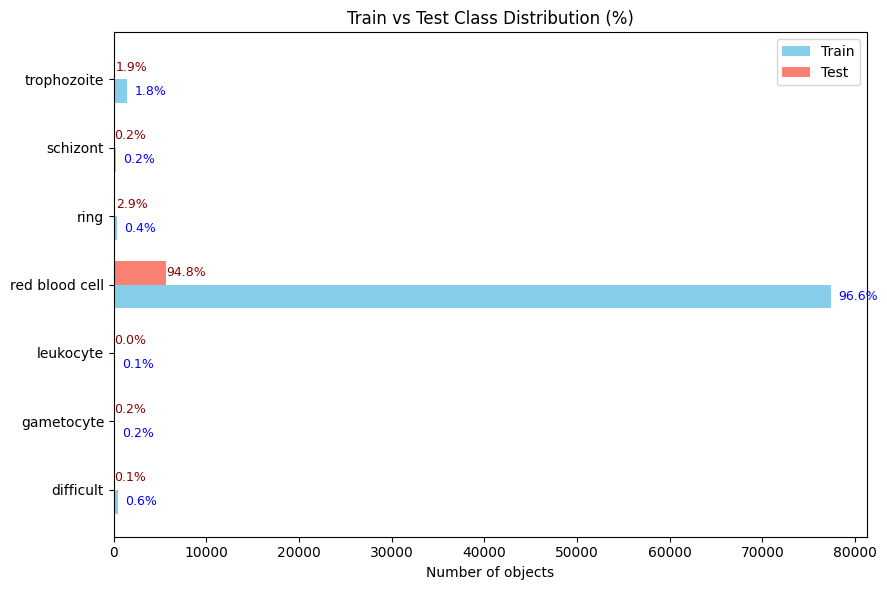

In [123]:
# check class imbalance in train images and visualize

# function to load class counts from a JSON file
def get_class_counts(json_path):
    with open(json_path) as f:
        data = json.load(f)
    if isinstance(data[0], list):
        data = data[0]
    categories = []
    for item in data:
        for obj in item["objects"]:
            categories.append(obj["category"])
    counts = Counter(categories)
    total = sum(counts.values())
    percentages = {cls: (count / total) * 100 for cls, count in counts.items()}
    return counts, percentages

# Load train and test sets ---
train_counts, train_perc = get_class_counts(os.path.join("/content/drive/MyDrive/malaria/labels", "train.json"))
test_counts, test_perc = get_class_counts(os.path.join("/content/drive/MyDrive/malaria/labels", "test.json"))

# Ensure consistent class order
all_classes = sorted(set(train_counts.keys()) | set(test_counts.keys()))

# Prepare data
train_vals = [train_counts.get(c, 0) for c in all_classes]
test_vals = [test_counts.get(c, 0) for c in all_classes]
train_pct = [train_perc.get(c, 0) for c in all_classes]
test_pct = [test_perc.get(c, 0) for c in all_classes]

# Print summary
print("TRAIN set:")
for c in all_classes:
    print(f"{c}: {train_counts.get(c, 0)} ({train_perc.get(c, 0):.2f}%)")
print("\n TEST set:")
for c in all_classes:
    print(f"{c}: {test_counts.get(c, 0)} ({test_perc.get(c, 0):.2f}%)")

# Plot side by side horizontal bars
y = np.arange(len(all_classes))
bar_height = 0.35

plt.figure(figsize=(9, 6))
plt.barh(y - bar_height/2, train_vals, height=bar_height, color='skyblue', label='Train')
plt.barh(y + bar_height/2, test_vals, height=bar_height, color='salmon', label='Test')

# Add percentage labels to the right
for i, c in enumerate(all_classes):
    plt.text(train_vals[i] + max(train_vals)*0.01, y[i] - bar_height/2,
             f"{train_pct[i]:.1f}%", va='center', fontsize=9, color='blue')
    plt.text(test_vals[i] + max(test_vals)*0.01, y[i] + bar_height/2,
             f"{test_pct[i]:.1f}%", va='center', fontsize=9, color='darkred')

plt.yticks(y, all_classes)
plt.xlabel("Number of objects")
plt.title("Train vs Test Class Distribution (%)")
plt.legend()
plt.tight_layout()
plt.show()

There is class imbalance. The red blood cell cateory is the most class.

### **1.6.15 Convert existing JSON annotation format to the YOLOv8 format.**

YOLOv8 format (TXT files with normalized bounding box coordinates).

In [124]:
# Function to convert bounding box to YOLO format
def to_yolo(box, img_w, img_h):
    # x_center, y_center, width, height normalized to image size
    x_min, y_min = box["minimum"]["c"], box["minimum"]["r"]
    x_max, y_max = box["maximum"]["c"], box["maximum"]["r"]

    x_center = (x_min + x_max) / 2.0
    y_center = (y_min + y_max) / 2.0
    width = x_max - x_min
    height = y_max - y_min

    # Normalize coordinates
    x_center /= img_w
    y_center /= img_h
    width /= img_w
    height /= img_h

    return x_center, y_center, width, height

# Create a mapping from category names to class IDs
category_to_id = {
    "red blood cell": 0,
    "trophozoite": 1,
    "schizont": 2,
    "difficult": 3,
    "ring": 4,
    "leukocyte": 5,
    "gametocyte": 6
}

# Create directories for YOLO labels
os.makedirs("labels/train", exist_ok=True)
os.makedirs("labels/test", exist_ok=True)

# Process training data
for item in train_data:
    img_name = os.path.basename(item["image"]["pathname"])
    img_w = item["image"]["shape"]["c"]
    img_h = item["image"]["shape"]["r"]
    label_file_name = os.path.splitext(img_name)[0] + ".txt"
    label_file_path = os.path.join("labels/train", label_file_name)

    with open(label_file_path, "w") as f:
        for obj in item["objects"]:
            category = obj["category"].lower().strip()
            if category in category_to_id:
                class_id = category_to_id[category]
                x_c, y_c, w, h = to_yolo(obj["bounding_box"], img_w, img_h)
                f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

# Process test data
for item in test_data:
    img_name = os.path.basename(item["image"]["pathname"])
    img_w = item["image"]["shape"]["c"]
    img_h = item["image"]["shape"]["r"]
    label_file_name = os.path.splitext(img_name)[0] + ".txt"
    label_file_path = os.path.join("labels/test", label_file_name)

    with open(label_file_path, "w") as f:
        for obj in item["objects"]:
            category = obj["category"].lower().strip()
            if category in category_to_id:
                class_id = category_to_id[category]
                x_c, y_c, w, h = to_yolo(obj["bounding_box"], img_w, img_h)
                f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

print("Conversion to YOLO format complete.")

Conversion to YOLO format complete.


### **1.6.16 Create a YAML configuration file for training.**

In [133]:
# Create the YAML configuration file for YOLOv8
yaml_config = {
    'path': '/content/drive/MyDrive/malaria',  # Dataset root directory
    'train': 'images/train',  # Train images (relative to 'path')
    'val': 'images/test',    # Validation images (relative to 'path') - using test for simplicity
    'test': 'images/test',   # Test images (relative to 'path') - using same for simplicity

    'nc': len(category_to_id),  # Number of classes
    'names': list(category_to_id.keys())  # Class names
}

# Save the YAML file
with open("malaria.yaml", "w") as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print("malaria.yaml created.")

malaria.yaml created.


In [134]:
# List some of the generated training label files
train_label_files = os.listdir("labels/train")
print("Example train label files:", train_label_files[:5])

Example train label files: ['8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.txt', '10be6380-cbbb-4886-8b9e-ff56b1710576.txt', '6b14c855-8561-417c-97a4-63fa552842fd.txt', '13099edb-35d9-438f-b093-2cf2ebf9d255.txt', '2559636b-f01a-4414-93da-210c3b12d153.txt']


In [135]:
# Display the content of the first few training label files
print("\nContent of first 2 train label files:")
for label_file in train_label_files[:2]:
    print(f"\n--- {label_file} ---")
    with open(os.path.join("labels/train", label_file), "r") as f:
        print(f.read())


Content of first 2 train label files:

--- 8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.txt ---
0 0.931250 0.922917 0.062500 0.084167
0 0.845625 0.766250 0.062500 0.085833
0 0.596250 0.527917 0.067500 0.092500
0 0.413750 0.296667 0.063750 0.086667
0 0.588750 0.212500 0.076250 0.095000
0 0.954375 0.202500 0.058750 0.083333
0 0.901875 0.258750 0.073750 0.089167
0 0.216875 0.401250 0.056250 0.085833
0 0.780937 0.670833 0.073125 0.096667
0 0.314375 0.866250 0.061250 0.079167
0 0.862187 0.673750 0.066875 0.089167
0 0.103125 0.360000 0.056250 0.071667
0 0.283750 0.323750 0.057500 0.065833
0 0.427500 0.750417 0.077500 0.092500
0 0.088125 0.107917 0.072500 0.094167
0 0.744062 0.741250 0.054375 0.089167
0 0.179063 0.329167 0.066875 0.076667
0 0.291563 0.234167 0.060625 0.086667
0 0.498125 0.645417 0.068750 0.084167
0 0.195000 0.233333 0.056250 0.085000
0 0.858125 0.848333 0.053750 0.068333
0 0.245938 0.739583 0.064375 0.092500
0 0.681875 0.157917 0.070000 0.084167
0 0.146563 0.172083 0.070625 0.094167

In [129]:
# List some of the generated test label files
test_label_files = os.listdir("labels/test")
print("Example test label files:", test_label_files[:5])

Example test label files: ['41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.txt', '64985a1e-16bb-4016-a01c-c21a5b86e572.txt', 'c70894fa-50e8-4eed-a5a8-159a20153a49.txt', 'abb72ce2-4193-4dd3-a34c-61c2ee22ccff.txt', '8db76867-671a-4488-a7b6-991e4dd2e05f.txt']


In [130]:
# Display the content of the first few test label files
print("\nContent of first 2 test label files:")
for label_file in test_label_files[:2]:
    print(f"\n--- {label_file} ---")
    with open(os.path.join("labels/test", label_file), "r") as f:
        print(f.read())


Content of first 2 test label files:

--- 41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.txt ---
0 0.932870 0.464208 0.071502 0.095445
0 0.674383 0.665221 0.063786 0.082430
0 0.844650 0.197035 0.070988 0.090383
0 0.611368 0.780550 0.066358 0.090383
0 0.879115 0.458062 0.055556 0.088937
0 0.703704 0.385756 0.062757 0.081706
0 0.342850 0.741504 0.073560 0.091829
0 0.909722 0.349964 0.071502 0.096891
0 0.427212 0.884309 0.065329 0.088214
0 0.367284 0.823933 0.061728 0.086045
0 0.724537 0.741142 0.072531 0.092552
0 0.500000 0.495300 0.063786 0.088214
0 0.713992 0.858279 0.070988 0.093999
0 0.281379 0.684743 0.072016 0.082430
0 0.247171 0.422270 0.072531 0.101229
0 0.960134 0.302242 0.066358 0.105568
0 0.056070 0.225235 0.077160 0.091829
0 0.425412 0.682936 0.074074 0.100506
0 0.126286 0.107737 0.061214 0.092552
0 0.797068 0.469270 0.064300 0.085322
0 0.607767 0.627260 0.052984 0.068691
0 0.799383 0.679320 0.073045 0.104845
0 0.482767 0.639190 0.065329 0.083876
0 0.821759 0.285973 0.073560 0.100506


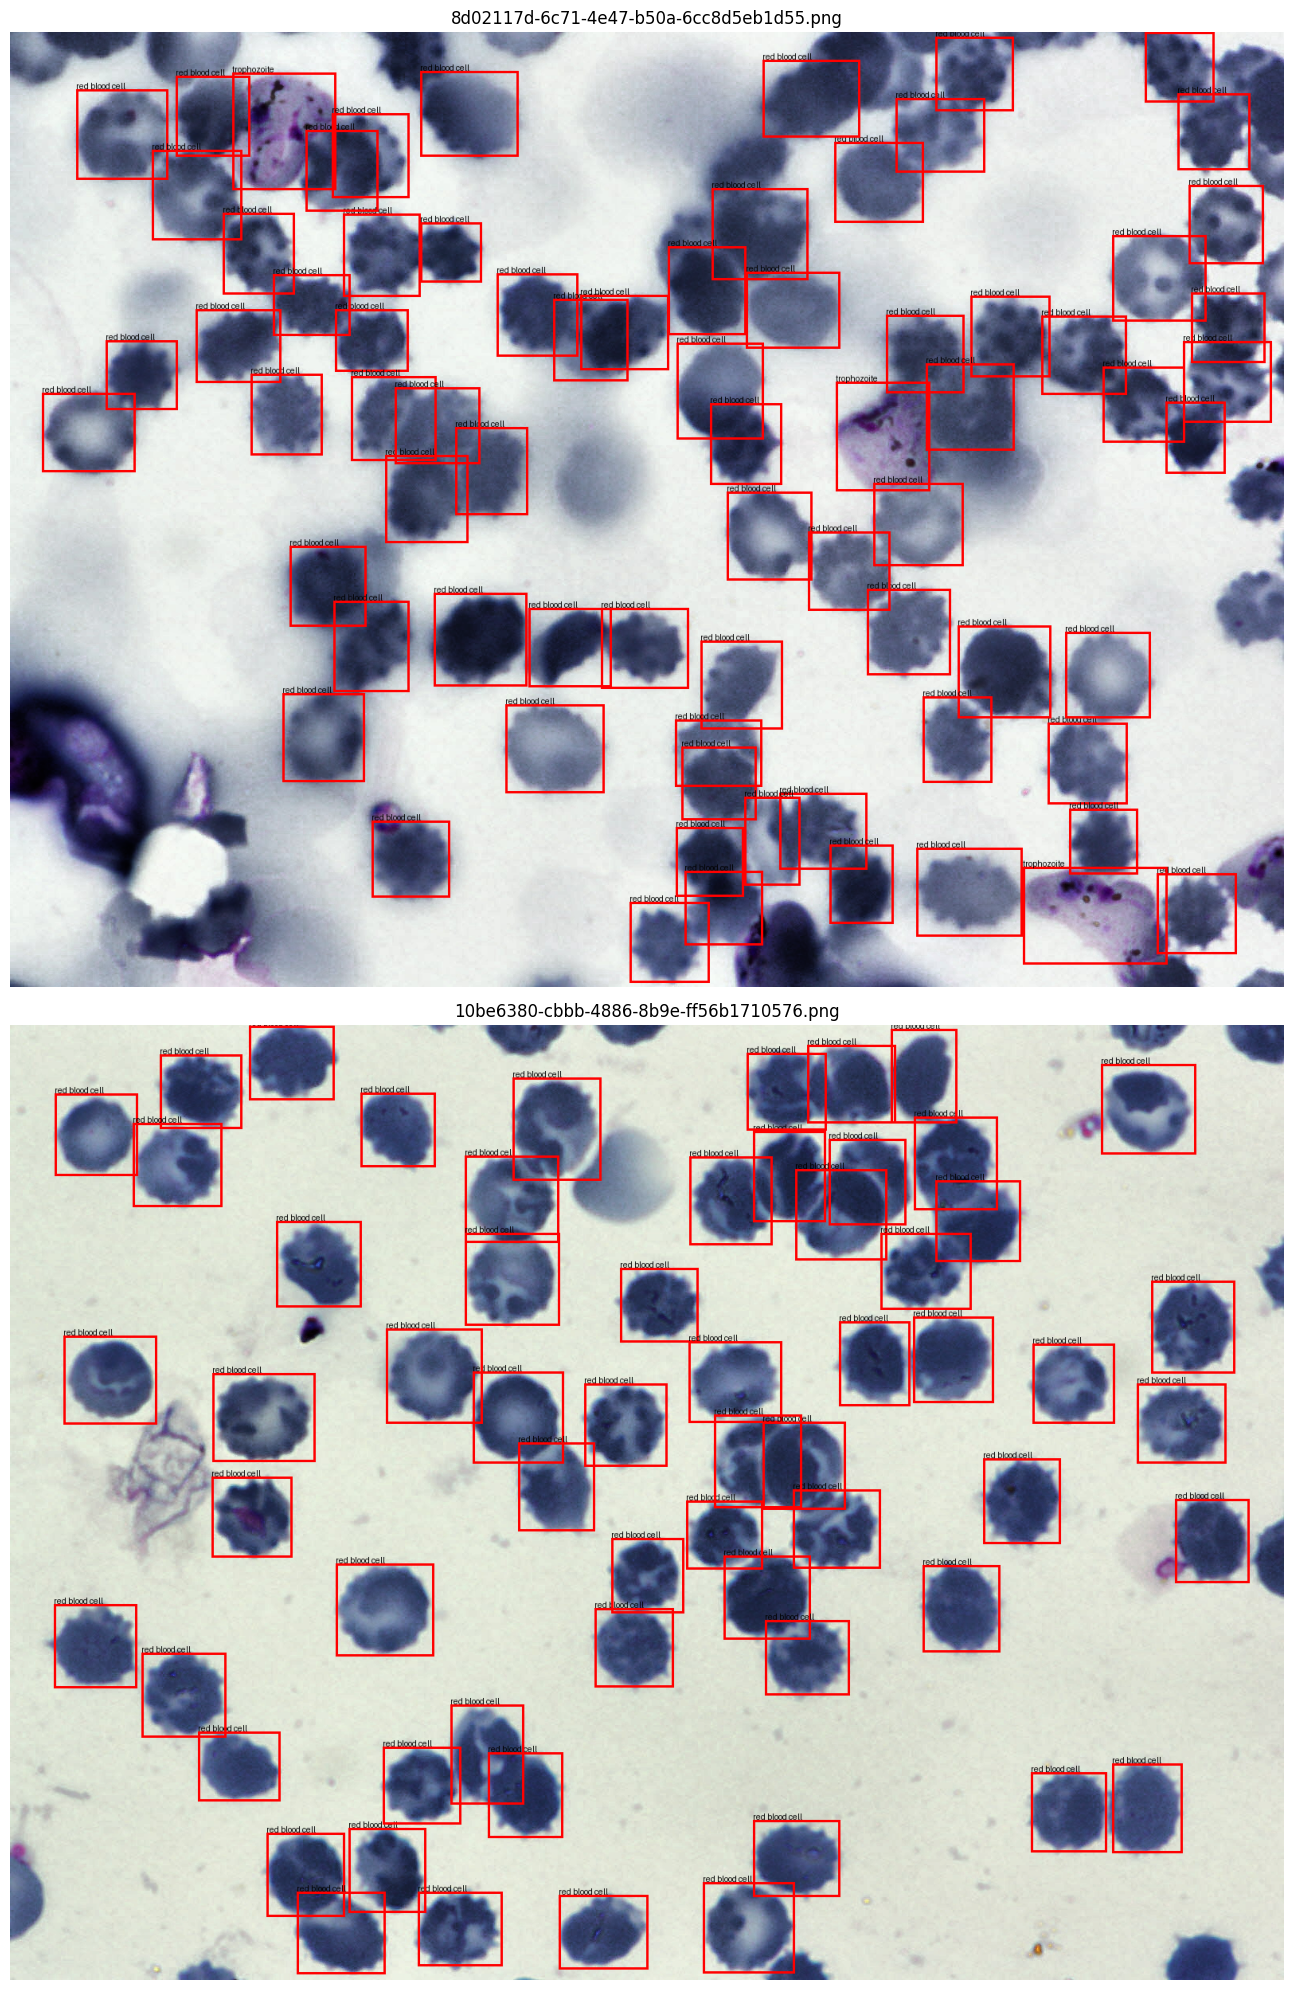

In [131]:
# Function to convert YOLO coordinates back to pixel coordinates
def from_yolo(x_center, y_center, width, height, img_w, img_h):
    xmin = int((x_center - width/2) * img_w)
    ymin = int((y_center - height/2) * img_h)
    xmax = int((x_center + width/2) * img_w)
    ymax = int((y_center + height/2) * img_h)
    return xmin, ymin, xmax, ymax

# Get the list of train label files again (if not already available)
train_label_files = os.listdir("labels/train")
image_folder = "/content/drive/MyDrive/malaria/images/train"

# Try loading a font (fallback to default)
try:
    font = ImageFont.truetype("arial.ttf", 34)
except:
    font = ImageFont.load_default()

plt.figure(figsize=(20, 20))

# Process the first two train label files
for idx, label_file in enumerate(train_label_files[:2]):
    img_name = os.path.splitext(label_file)[0] + ".png"
    img_path = os.path.join(image_folder, img_name)

    try:
        img = Image.open(img_path).convert("RGB")
        img_w, img_h = img.size
        draw = ImageDraw.Draw(img)

        label_file_path = os.path.join("labels/train", label_file)
        with open(label_file_path, "r") as f:
            for line in f:
                class_id, x_c, y_c, w, h = map(float, line.strip().split())
                xmin, ymin, xmax, ymax = from_yolo(x_c, y_c, w, h, img_w, img_h)

                # Get category name from class_id
                category = list(category_to_id.keys())[int(class_id)]

                draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
                draw.text((xmin, ymin - 10), category, fill="black", font=font)

        plt.subplot(2, 1, idx + 1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis("off")

    except FileNotFoundError:
        print(f"Image file not found: {img_path}")
    except Exception as e:
        print(f"Error processing image {img_name}: {e}")

plt.tight_layout()
plt.show()

## **1.7 Model Training**

In [136]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # load a pretrained model.
# yolov8n is the smallest size which is the fastest, has lowest parameters.A good baseline model size to start with.

# Train the model
model.train(data='malaria.yaml', epochs=100, imgsz=640, augment=True)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=malaria.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

KeyboardInterrupt: 